In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


In [3]:
# Focal Loss Function
def focal_loss(gamma=3.0, alpha=0.5):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)
        focal_loss = -y_true * (alpha * tf.math.pow(1 - y_pred, gamma) * tf.math.log(y_pred))
        return tf.reduce_sum(focal_loss, axis=-1)
    return focal_loss_fixed

In [4]:
# Define the MLP model with ReLU activation
def create_mlp_model(input_shape, num_classes):
    model = models.Sequential()
    model.add(layers.Flatten(input_shape=input_shape))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(num_classes, activation='softmax'))
    return model

In [5]:
num_classes = 2

# Load dataset hasil normalisasi
file_path_normalisasi = 'D:\Tugas Akhir\Stroke\hasil_setelah_normalisasi.csv'
df_normalisasi = pd.read_csv(file_path_normalisasi)

# Ganti koma dengan titik dan ubah tipe data ke float32 untuk kolom tertentu
columns_to_convert = ['age', 'avg_glucose_level', 'bmi']
df_normalisasi[columns_to_convert] = df_normalisasi[columns_to_convert].replace(',', '.', regex=True).astype('float32')

# Pisahkan fitur dan target untuk dataset hasil normalisasi
X_normalisasi = df_normalisasi.drop('stroke', axis=1)
y_normalisasi = df_normalisasi['stroke']

# Mengonversi target menjadi one-hot encoding untuk normalisasi
y_normalisasi_one_hot = tf.keras.utils.to_categorical(y_normalisasi, num_classes)

# Pastikan tipe data float32 untuk fitur
X_normalisasi = X_normalisasi.astype('float32')


# Load dataset hasil oversampling ADASYN
file_path_oversampled = 'D:\Tugas Akhir\Stroke\data_oversampled.csv'
df_oversampled = pd.read_csv(file_path_oversampled)

# Ganti koma dengan titik dan ubah tipe data ke float32 untuk kolom tertentu
columns_to_convert = ['age', 'avg_glucose_level', 'bmi']
df_oversampled[columns_to_convert] = df_oversampled[columns_to_convert].replace(',', '.', regex=True).astype('float32')

# Pisahkan fitur dan target untuk dataset hasil oversampling ADASYN
X_oversampled = df_oversampled.drop('stroke', axis=1)
y_oversampled = df_oversampled['stroke']

# Mengonversi target menjadi one-hot encoding untuk ADASYN
y_oversampled_one_hot = tf.keras.utils.to_categorical(y_oversampled, num_classes)

# Pastikan tipe data float32 untuk fitur
X_oversampled = X_oversampled.astype('float32')


# Load dataset hasil PCA-KMeans
file_path_pca_kmeans = 'D:/Tugas Akhir/Stroke/data_hasil_nearmiss.csv'
df_pca_kmeans = pd.read_csv(file_path_pca_kmeans)

# Pisahkan fitur dan target untuk dataset hasil PCA-KMeans
X_pca_kmeans = df_pca_kmeans.drop(['stroke', 'Cluster'], axis=1)
y_pca_kmeans = df_pca_kmeans['stroke']

# Mengonversi target menjadi one-hot encoding untuk PCA-KMeans
y_pca_kmeans_one_hot = tf.keras.utils.to_categorical(y_pca_kmeans, num_classes)

# Pastikan tipe data float32 untuk fitur
X_pca_kmeans = X_pca_kmeans.astype('float32')

In [6]:
df_normalisasi

,gender,age,hypertension,heart_disease,ever_married,work_type_Govt_job,work_type_Private,work_type_Self-employed,Residence_type,avg_glucose_level,bmi,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,stroke
0,0,0.7368,0,1,1,0,1,0,0,0.8012,0.5227,0,1,0,0,1
1,0,0.9649,0,1,1,0,1,0,1,0.2342,0.4380,0,0,1,0,1
2,1,0.4211,0,0,1,0,1,0,0,0.5358,0.4773,0,0,0,1,1
3,1,0.9474,1,0,1,0,0,1,1,0.5491,0.2624,0,0,1,0,1
4,0,0.9825,0,0,1,0,1,0,0,0.6050,0.3657,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3684,1,0.5614,0,0,1,0,1,0,1,0.1049,0.2149,0,0,1,0,0
3685,1,0.9825,0,0,1,0,0,1,0,0.3232,0.5930,0,0,1,0,0
3686,1,0.1754,0,0,1,0,0,1,1,0.1283,0.3988,0,0,1,0,0
3687,0,0.4561,0,0,1,0,1,0,1,0.5130,0.2955,0,1,0,0,0


In [7]:
df_oversampled

,gender,age,hypertension,heart_disease,ever_married,work_type_Govt_job,work_type_Private,work_type_Self-employed,Residence_type,avg_glucose_level,bmi,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,stroke
0,0,0.736800,0,1,1,0,1,0,0,0.801200,0.522700,0,1,0,0,1
1,0,0.964900,0,1,1,0,1,0,1,0.234200,0.438000,0,0,1,0,1
2,1,0.421100,0,0,1,0,1,0,0,0.535800,0.477300,0,0,0,1,1
3,1,0.947400,1,0,1,0,0,1,1,0.549100,0.262400,0,0,1,0,1
4,0,0.982500,0,0,1,0,1,0,0,0.605000,0.365700,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5766,1,0.880409,0,0,1,0,1,0,1,0.631082,0.307279,1,0,0,0,1
5767,0,0.858301,0,0,1,0,1,0,1,0.140335,0.254772,1,0,0,0,1
5768,1,0.929800,0,0,1,0,1,0,0,0.090441,0.190357,1,0,0,0,1
5769,1,0.900879,0,0,1,0,1,0,1,0.209695,0.238608,1,0,0,0,1


In [8]:
df_pca_kmeans

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,stroke,Cluster
0,0.068107,-0.088542,1.939074,-0.627741,-0.023600,0.172116,-0.646637,-0.178935,-1.112385,0.617090,-0.557427,-0.852989,1.269409,0,3
1,-0.372311,-0.288131,1.778789,-0.524434,0.039406,0.072837,-0.461260,-0.051620,-1.069997,0.483854,-0.548799,-0.705220,0.623753,0,2
2,-0.497360,-0.306754,1.771379,-0.429053,0.105563,0.117476,-0.254384,0.013522,-1.057801,0.420387,-0.624158,-0.653482,0.410506,0,4
3,-0.553266,-0.274984,1.818072,-0.325434,0.145386,0.204719,-0.129008,0.097463,-1.006663,0.436374,-0.748541,-0.940615,0.092452,0,1
4,-0.615812,-0.345870,1.598231,-0.213296,-0.069907,0.027908,-0.002357,-1.253786,0.424644,0.306286,-0.614044,-0.655903,0.101249,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
523,0.345868,0.990180,2.426873,0.501795,0.661659,1.428750,0.694201,0.770974,-0.604728,-1.257451,-1.191597,-1.279206,0.886686,1,4
524,2.518617,3.816928,2.039622,1.036978,0.859396,0.882988,0.387169,0.000869,1.419507,2.660340,-0.665535,0.854201,-1.523132,1,0
525,-0.872821,1.118255,-0.778655,-1.291987,0.286761,1.786304,0.021523,0.558588,-0.773695,-1.142540,0.250701,0.521782,0.605546,1,2
526,2.387014,0.075662,-0.949177,-1.419237,0.255891,-2.077057,0.444078,0.268761,-1.176065,0.295820,-0.275126,0.232774,0.529735,1,0


In [9]:
# Hitung frekuensi nilai unik dalam kolom 'stroke'
stroke_counts = df_normalisasi['stroke'].value_counts()
# Tampilkan output
print("Data Pada Normalisasi 'stroke':")
print(stroke_counts)

# Hitung frekuensi nilai unik dalam kolom 'stroke'
stroke_counts = df_oversampled['stroke'].value_counts()
# Tampilkan output
print("Data Pada ADASYN 'stroke':")
print(stroke_counts)

# Hitung frekuensi nilai unik dalam kolom 'stroke'
stroke_counts = df_pca_kmeans['stroke'].value_counts()
# Tampilkan output
print("Data Pada PCA-KMeans 'stroke':")
print(stroke_counts)

Data Pada Normalisasi 'stroke':
stroke
0    3481
1     208
Name: count, dtype: int64
Data Pada ADASYN 'stroke':
stroke
0    3481
1    2290
Name: count, dtype: int64
Data Pada PCA-KMeans 'stroke':
stroke
0    320
1    208
Name: count, dtype: int64


In [10]:
# Pisahkan data normalisasi menjadi set pelatihan dan pengujian
X_train_normalisasi, X_test_normalisasi, y_train_normalisasi, y_test_normalisasi = train_test_split(X_normalisasi, y_normalisasi, test_size=0.2, random_state=42)

# Pisahkan data ADASYN menjadi set pelatihan dan pengujian
X_train_oversampled, X_test_oversampled, y_train_oversampled, y_test_oversampled = train_test_split(X_oversampled, y_oversampled, test_size=0.2, random_state=42)

# Pisahkan data PCA-KMeans menjadi set pelatihan dan pengujian
X_train_pca_kmeans, X_test_pca_kmeans, y_train_pca_kmeans, y_test_pca_kmeans = train_test_split(X_pca_kmeans, y_pca_kmeans, test_size=0.2, random_state=42)


In [11]:
import numpy as np
# Menghitung jumlah kelas 0 dan 1 pada normalisasi (data latih)
unique_normalisasi_train, counts_normalisasi_train = np.unique(y_train_normalisasi, return_counts=True)
num_class_0_normalisasi_train = counts_normalisasi_train[unique_normalisasi_train == 0][0]
num_class_1_normalisasi_train = counts_normalisasi_train[unique_normalisasi_train == 1][0]

# Menghitung jumlah kelas 0 dan 1 pada normalisasi (data uji)
unique_normalisasi_test, counts_normalisasi_test = np.unique(y_test_normalisasi, return_counts=True)
num_class_0_normalisasi_test = counts_normalisasi_test[unique_normalisasi_test == 0][0]
num_class_1_normalisasi_test = counts_normalisasi_test[unique_normalisasi_test == 1][0]

print("Data Latih Normalisasi:")
print(f"Jumlah data latih: {len(y_train_normalisasi)}")
print(f"Jumlah kelas 0: {num_class_0_normalisasi_train}")
print(f"Jumlah kelas 1: {num_class_1_normalisasi_train}")
print("\nData Uji Normalisasi:")
print(f"Jumlah data uji: {len(y_test_normalisasi)}")
print(f"Jumlah kelas 0: {num_class_0_normalisasi_test}")
print(f"Jumlah kelas 1: {num_class_1_normalisasi_test}")
print("===========================================")

# Menghitung jumlah kelas 0 dan 1 pada ADASYN (data latih)
unique_oversampled_train, counts_oversampled_train = np.unique(y_train_oversampled, return_counts=True)
num_class_0_oversampled_train = counts_oversampled_train[unique_oversampled_train == 0][0]
num_class_1_oversampled_train = counts_oversampled_train[unique_oversampled_train == 1][0]

# Menghitung jumlah kelas 0 dan 1 pada ADASYN (data uji)
unique_oversampled_test, counts_oversampled_test = np.unique(y_test_oversampled, return_counts=True)
num_class_0_oversampled_test = counts_oversampled_test[unique_oversampled_test == 0][0]
num_class_1_oversampled_test = counts_oversampled_test[unique_oversampled_test == 1][0]

print("Data Latih ADASYN:")
print(f"Jumlah data latih: {len(y_train_oversampled)}")
print(f"Jumlah kelas 0: {num_class_0_oversampled_train}")
print(f"Jumlah kelas 1: {num_class_1_oversampled_train}")
print("\nData Uji ADASYN:")
print(f"Jumlah data uji: {len(y_test_oversampled)}")
print(f"Jumlah kelas 0: {num_class_0_oversampled_test}")
print(f"Jumlah kelas 1: {num_class_1_oversampled_test}")
print("===========================================")

# Menghitung jumlah kelas 0 dan 1 pada PCA-KMeans (data latih)
unique_pca_kmeans_train, counts_pca_kmeans_train = np.unique(y_train_pca_kmeans, return_counts=True)
num_class_0_pca_kmeans_train = counts_pca_kmeans_train[unique_pca_kmeans_train == 0][0]
num_class_1_pca_kmeans_train = counts_pca_kmeans_train[unique_pca_kmeans_train == 1][0]

# Menghitung jumlah kelas 0 dan 1 pada PCA-KMeans (data uji)
unique_pca_kmeans_test, counts_pca_kmeans_test = np.unique(y_test_pca_kmeans, return_counts=True)
num_class_0_pca_kmeans_test = counts_pca_kmeans_test[unique_pca_kmeans_test == 0][0]
num_class_1_pca_kmeans_test = counts_pca_kmeans_test[unique_pca_kmeans_test == 1][0]

print("Data Latih PCA-KMeans:")
print(f"Jumlah data latih: {len(y_train_pca_kmeans)}")
print(f"Jumlah kelas 0: {num_class_0_pca_kmeans_train}")
print(f"Jumlah kelas 1: {num_class_1_pca_kmeans_train}")
print("\nData Uji PCA-KMeans:")
print(f"Jumlah data uji: {len(y_test_pca_kmeans)}")
print(f"Jumlah kelas 0: {num_class_0_pca_kmeans_test}")
print(f"Jumlah kelas 1: {num_class_1_pca_kmeans_test}")
print("===========================================")


Data Latih Normalisasi:
Jumlah data latih: 2951
Jumlah kelas 0: 2789
Jumlah kelas 1: 162

Data Uji Normalisasi:
Jumlah data uji: 738
Jumlah kelas 0: 692
Jumlah kelas 1: 46
Data Latih ADASYN:
Jumlah data latih: 4616
Jumlah kelas 0: 2788
Jumlah kelas 1: 1828

Data Uji ADASYN:
Jumlah data uji: 1155
Jumlah kelas 0: 693
Jumlah kelas 1: 462
Data Latih PCA-KMeans:
Jumlah data latih: 422
Jumlah kelas 0: 253
Jumlah kelas 1: 169

Data Uji PCA-KMeans:
Jumlah data uji: 106
Jumlah kelas 0: 67
Jumlah kelas 1: 39


In [12]:
# Menetapkan bentuk input dan jumlah kelas berdasarkan fitur dan target untuk Normalisasi
input_shape_normalisasi = X_train_normalisasi.shape[1:]
num_classes_normalisasi = y_normalisasi_one_hot.shape[1]  # Disesuaikan untuk mendapatkan jumlah kelas secara dinamis
y_train_normalisasi_one_hot = tf.keras.utils.to_categorical(y_train_normalisasi, num_classes_normalisasi)
y_test_normalisasi_one_hot = tf.keras.utils.to_categorical(y_test_normalisasi, num_classes_normalisasi)

# Menetapkan bentuk input dan jumlah kelas berdasarkan fitur dan target untuk ADASYN
input_shape_adasyn = X_train_oversampled.shape[1:]
num_classes_adasyn = y_oversampled_one_hot.shape[1]  # Disesuaikan untuk mendapatkan jumlah kelas secara dinamis
y_train_oversampled_one_hot = tf.keras.utils.to_categorical(y_train_oversampled, num_classes_adasyn)
y_test_oversampled_one_hot = tf.keras.utils.to_categorical(y_test_oversampled, num_classes_adasyn)

# Menetapkan bentuk input dan jumlah kelas berdasarkan fitur dan target untuk PCA-KMeans
input_shape_pca_kmeans = X_train_pca_kmeans.shape[1:]
num_classes_pca_kmeans = y_pca_kmeans_one_hot.shape[1]  # Disesuaikan untuk mendapatkan jumlah kelas secara dinamis
y_train_pca_kmeans_one_hot = tf.keras.utils.to_categorical(y_train_pca_kmeans, num_classes_pca_kmeans)
y_test_pca_kmeans_one_hot = tf.keras.utils.to_categorical(y_test_pca_kmeans, num_classes_pca_kmeans)

In [13]:
# Create the MLP model for ADASYN
model_normalisasi = create_mlp_model(input_shape_normalisasi, num_classes_normalisasi)

# Compile the model with Focal Loss
model_normalisasi.compile(optimizer='adam',
                     loss=focal_loss(),
                     metrics=['accuracy'])

# Create the MLP model for ADASYN
model_adasyn = create_mlp_model(input_shape_adasyn, num_classes_adasyn)

# Compile the model with Focal Loss
model_adasyn.compile(optimizer='adam',
                     loss=focal_loss(),
                     metrics=['accuracy'])

# Create the MLP model for PCA-KMeans
model_pca_kmeans = create_mlp_model(input_shape_pca_kmeans, num_classes_pca_kmeans)

# Compile the model with Focal Loss
model_pca_kmeans.compile(optimizer='adam',
                         loss=focal_loss(),
                         metrics=['accuracy'])



In [14]:
# Calculate class weights for normalisasi
class_weights_normalisasi = {0: num_class_1_normalisasi_train / num_class_0_normalisasi_train, 1: 1.0}

# Print model summary for Normalisasi
model_normalisasi.summary()

# Train the model for Normalisasi with class weights
history_normalisasi = model_normalisasi.fit(X_train_normalisasi, y_train_normalisasi_one_hot, epochs=50, batch_size=32,
                                  validation_split=0.2, class_weight=class_weights_normalisasi)
# Evaluate the model on the test set for Normalisasi
test_loss_normalisasi, test_acc_normalisasi = model_normalisasi.evaluate(X_test_normalisasi, y_test_normalisasi_one_hot)
print(f'Test Loss (Normalisasi): {test_loss_normalisasi}, Test Accuracy (Normalisasi): {test_acc_normalisasi}')

# Predict classes for the test set for Normalisasi
y_pred_probabilities_normalisasi = model_normalisasi.predict(X_test_normalisasi)
y_pred_normalisasi = y_pred_probabilities_normalisasi.argmax(axis=1)

# Convert one-hot encoded y_test back to numerical values for Normalisasi
y_true_normalisasi = np.array(y_test_normalisasi)

# Calculate precision, recall, and F1-score for Normalisasi
report_normalisasi = classification_report(y_true_normalisasi, y_pred_normalisasi)
print("Classification Report (Normalisasi):\n", report_normalisasi)

# Confusion Matrix for Normalisasi
conf_matrix_normalisasi = confusion_matrix(y_true_normalisasi, y_pred_normalisasi)
print("Confusion Matrix (Normalisasi):\n", conf_matrix_normalisasi)

# Calculate class weights for ADASYN
class_weights_adasyn = {0: num_class_1_oversampled_train / num_class_0_oversampled_train, 1: 1.0}

# Print model summary for ADASYN
model_adasyn.summary()

# Train the model for ADASYN with class weights
history_adasyn = model_adasyn.fit(X_train_oversampled, y_train_oversampled_one_hot, epochs=50, batch_size=32,
                                  validation_split=0.2, class_weight=class_weights_adasyn)
# Evaluate the model on the test set for ADASYN
test_loss_adasyn, test_acc_adasyn = model_adasyn.evaluate(X_test_oversampled, y_test_oversampled_one_hot)
print(f'Test Loss (ADASYN): {test_loss_adasyn}, Test Accuracy (ADASYN): {test_acc_adasyn}')

# Predict classes for the test set for ADASYN
y_pred_probabilities_adasyn = model_adasyn.predict(X_test_oversampled)
y_pred_adasyn = y_pred_probabilities_adasyn.argmax(axis=1)

# Convert one-hot encoded y_test back to numerical values for ADASYN
y_true_adasyn = np.array(y_test_oversampled)

# Calculate precision, recall, and F1-score for ADASYN
report_adasyn = classification_report(y_true_adasyn, y_pred_adasyn)
print("Classification Report (ADASYN):\n", report_adasyn)

# Confusion Matrix for ADASYN
conf_matrix_adasyn = confusion_matrix(y_true_adasyn, y_pred_adasyn)
print("Confusion Matrix (ADASYN):\n", conf_matrix_adasyn)


# Calculate class weights for PCA-KMeans
class_weights_pca_kmeans = {0: num_class_1_pca_kmeans_train / num_class_0_pca_kmeans_train, 1: 1.0}

# Print model summary for PCA-KMeans
model_pca_kmeans.summary()

# Train the model for PCA-KMeans with class weights
history_pca_kmeans = model_pca_kmeans.fit(X_train_pca_kmeans, y_train_pca_kmeans_one_hot, epochs=50, batch_size=32,
                                          validation_split=0.2, class_weight=class_weights_pca_kmeans)

# Evaluate the model on the test set for PCA-KMeans
test_loss_pca_kmeans, test_acc_pca_kmeans = model_pca_kmeans.evaluate(X_test_pca_kmeans, y_test_pca_kmeans_one_hot)
print(f'Test Loss (PCA-KMeans): {test_loss_pca_kmeans}, Test Accuracy (PCA-KMeans): {test_acc_pca_kmeans}')

# Predict classes for the test set for PCA-KMeans
y_pred_probabilities_pca_kmeans = model_pca_kmeans.predict(X_test_pca_kmeans)
y_pred_pca_kmeans = y_pred_probabilities_pca_kmeans.argmax(axis=1)

# Convert one-hot encoded y_test back to numerical values for PCA-KMeans
y_true_pca_kmeans = y_test_pca_kmeans.to_numpy()

# Calculate precision, recall, and F1-score for PCA-KMeans
report_pca_kmeans = classification_report(y_true_pca_kmeans, y_pred_pca_kmeans)
print("Classification Report (PCA-KMeans):\n", report_pca_kmeans)

# Confusion Matrix for PCA-KMeans
conf_matrix_pca_kmeans = confusion_matrix(y_true_pca_kmeans, y_pred_pca_kmeans)
print("Confusion Matrix (PCA-KMeans):\n", conf_matrix_pca_kmeans)



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 15)                0         
                                                                 
 dense (Dense)               (None, 128)               2048      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 2)                 130       
                                                                 
Total params: 10434 (40.76 KB)
Trainable params: 10434 (40.76 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
74/74 [==============================] - 1s 4ms/step - loss: 0.0047 - accuracy: 0.5996 - val_loss: 0.0353 - val_accuracy: 0.7428
Epoch 2/50
7

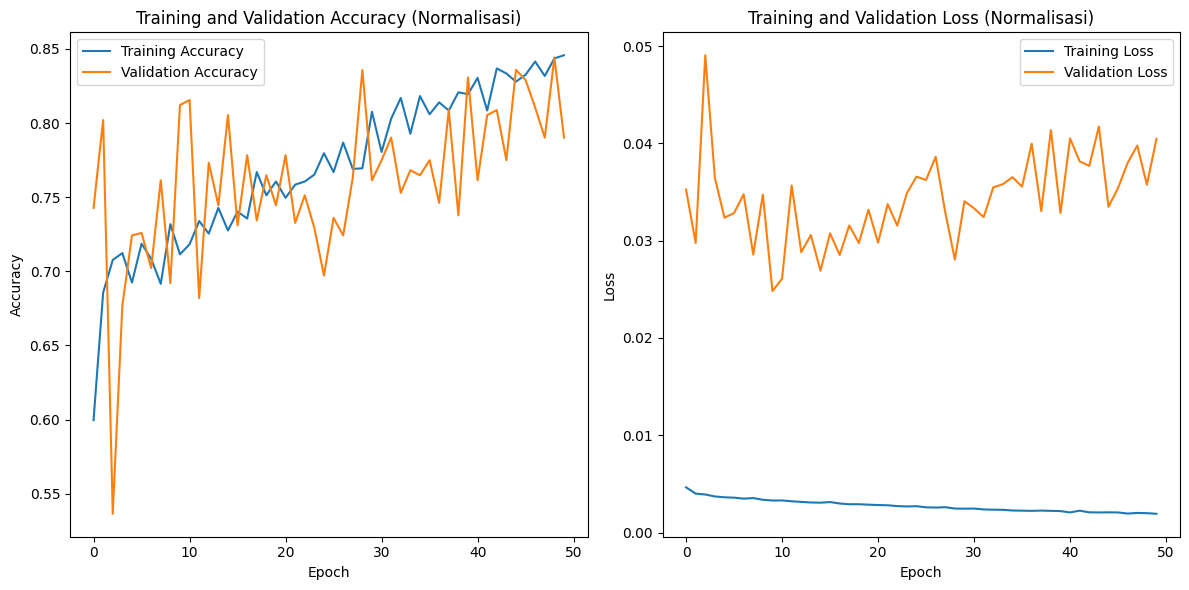

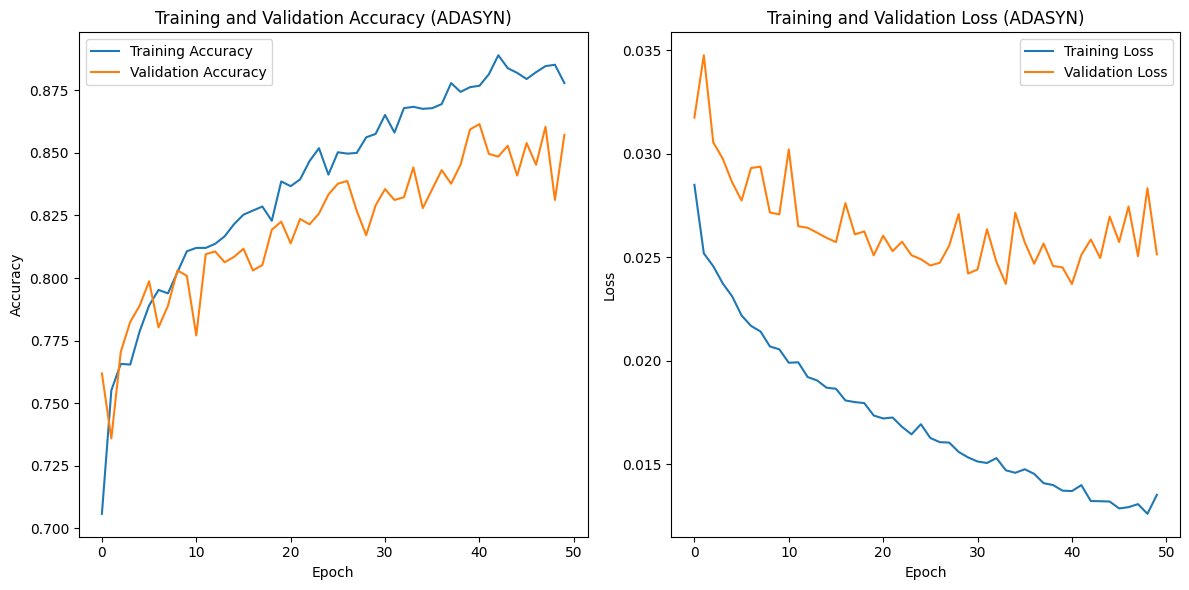

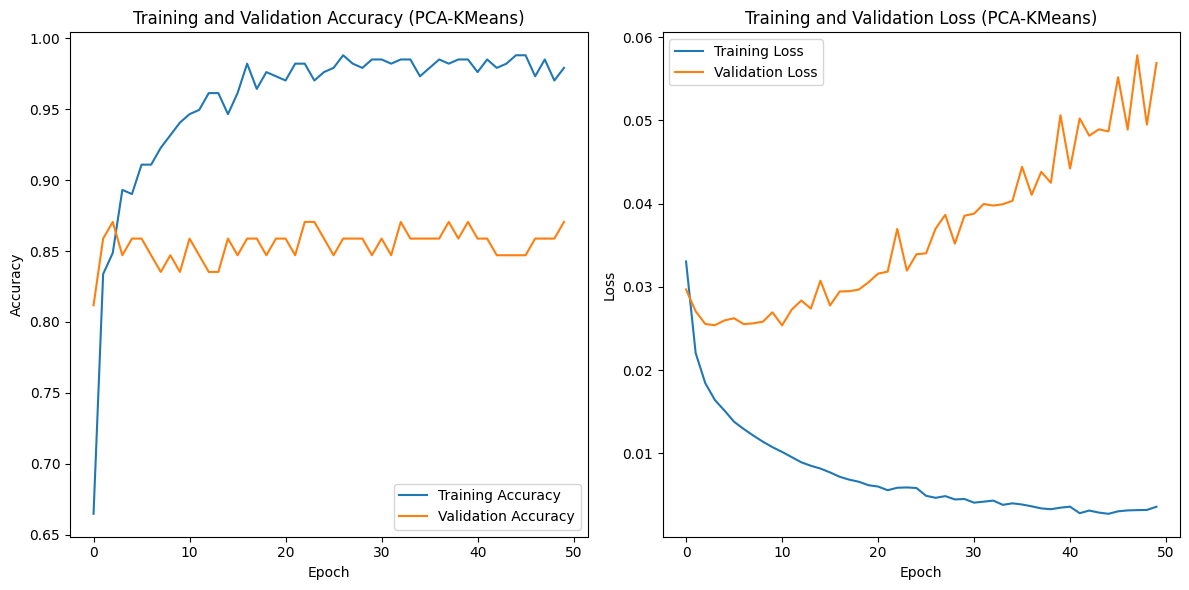

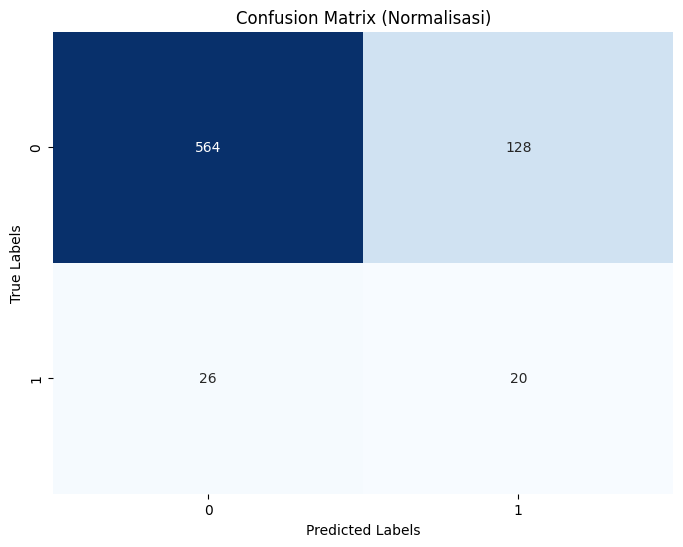

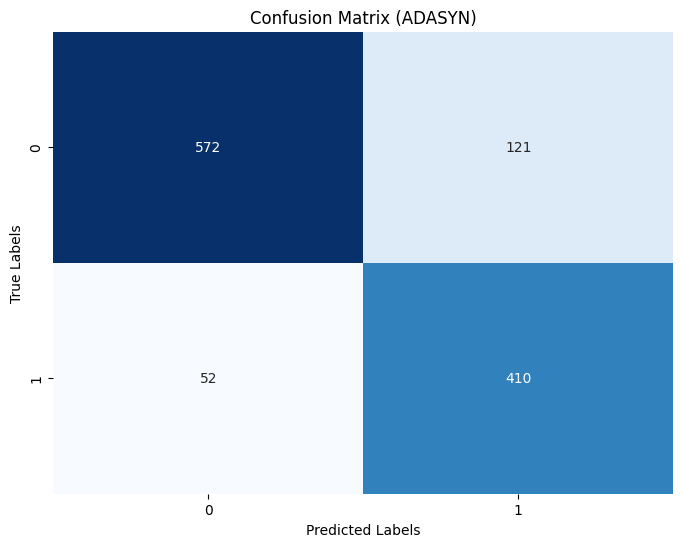

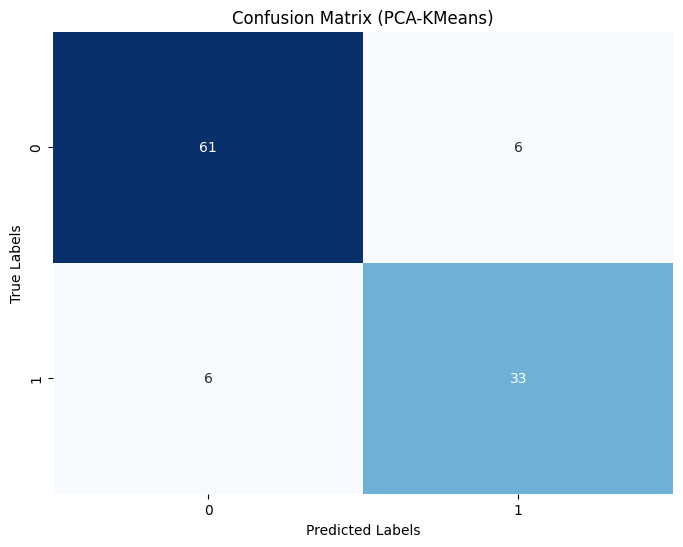

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay
# Visualisasi Akurasi dan Loss untuk Normalisasi
plt.figure(figsize=(12, 6))

# Plot Akurasi
plt.subplot(1, 2, 1)
plt.plot(history_normalisasi.history['accuracy'], label='Training Accuracy')
plt.plot(history_normalisasi.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy (Normalisasi)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history_normalisasi.history['loss'], label='Training Loss')
plt.plot(history_normalisasi.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss (Normalisasi)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Visualisasi Akurasi dan Loss untuk ADASYN
plt.figure(figsize=(12, 6))

# Plot Akurasi
plt.subplot(1, 2, 1)
plt.plot(history_adasyn.history['accuracy'], label='Training Accuracy')
plt.plot(history_adasyn.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy (ADASYN)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history_adasyn.history['loss'], label='Training Loss')
plt.plot(history_adasyn.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss (ADASYN)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Visualisasi Akurasi dan Loss untuk PCA-KMeans
plt.figure(figsize=(12, 6))

# Plot Akurasi
plt.subplot(1, 2, 1)
plt.plot(history_pca_kmeans.history['accuracy'], label='Training Accuracy')
plt.plot(history_pca_kmeans.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy (PCA-KMeans)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history_pca_kmeans.history['loss'], label='Training Loss')
plt.plot(history_pca_kmeans.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss (PCA-KMeans)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Visualisasi Confusion Matrix untuk Normalisasi
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_normalisasi, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix (Normalisasi)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Visualisasi Confusion Matrix untuk ADASYN
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_adasyn, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix (ADASYN)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Visualisasi Confusion Matrix untuk PCA-KMeans
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_pca_kmeans, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix (PCA-KMeans)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


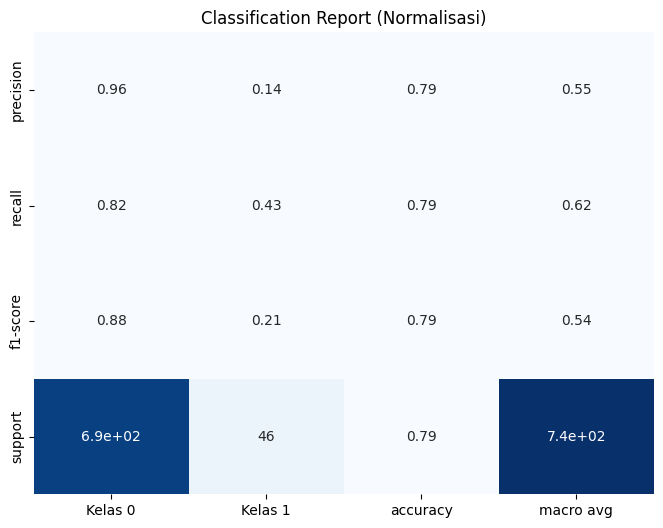

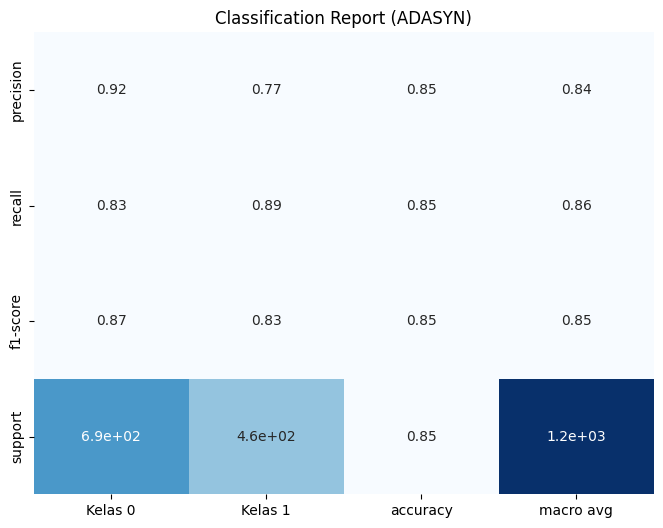

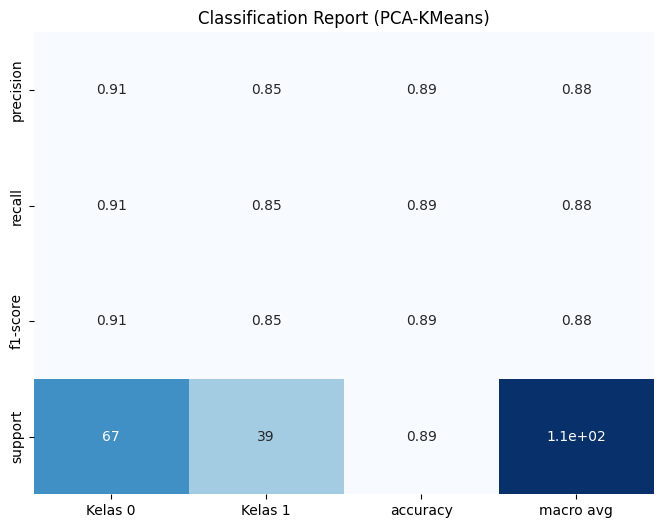

In [16]:
from sklearn.metrics import classification_report

# Fungsi untuk plotting classification report
def plot_classification_report(y_true, y_pred, title):
    report = classification_report(y_true, y_pred, target_names=['Kelas 0', 'Kelas 1'], output_dict=True)
    
    # Convert dictionary to DataFrame for better visualization
    report_df = pd.DataFrame(report).transpose()
    
    # Visualize Classification Report
    plt.figure(figsize=(8, 6))
    sns.heatmap(report_df.iloc[:-1, :].T, annot=True, cmap='Blues', cbar=False)
    plt.title(f'Classification Report ({title})')
    plt.show()
# Visualisasi Classification Report untuk Normalisasi
plot_classification_report(y_true_normalisasi, y_pred_normalisasi, 'Normalisasi')

# Visualisasi Classification Report untuk ADASYN
plot_classification_report(y_true_adasyn, y_pred_adasyn, 'ADASYN')

# Visualisasi Classification Report untuk PCA-KMeans
plot_classification_report(y_true_pca_kmeans, y_pred_pca_kmeans, 'PCA-KMeans')
